# Analyze Nodes picked by CELF and Social Score
This file explore network structure of nodes selected by CELF and social score. We analyze DNC email network properties and how they influence node selection. 

Perform following structural analysis such as 

    1. Identify # of connected components and SCC size
    2. Get Egonet size and plot Egonet of top most node 
    3. Compute Harmonic, Katz index and Node Betweeness 
    4. Perform k-Core decomposition compare if CELF and Social score nodes are in K-core network 
    5. Identify community using greedy modularity maximization algorithm (Louvain/Clauset-Newman)
    6. Look at eigenvalues of adjacency matrix 
    7. Spectral analysis to understand network structure 
    8. Identify bridge links and nodes in SCC 
    
  

In [1]:
import snap 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
import csv 

from datetime import datetime
from matplotlib.pyplot import loglog 
from scipy import optimize

from modifiedSocialScore import GenerateGraph, GenerateDirectedNxGraph, GeneratePrunedDirectedGraph

%matplotlib inline

In [2]:
#
# Load adjacency list as a pandas dataframe 
#
df, _ = GenerateGraph(filename='/home/merchantsameer2014/project/dnc-temporalGraph/out.dnc-temporalGraph')

In [3]:
#
# Build a networkx directed multigraph 
#   - Edge represents src sent an email to destination 
#
GNx = GenerateDirectedNxGraph(df)

In [4]:
# 
# Build an networkx undirected graph of nodes that have exchanged more than 4 emails 
#
uGNx = GeneratePrunedDirectedGraph(GNx, N=0)
#uGNx.remove_edges_from(nx.selfloop_edges(uGNx))

## Connected Components 

In [5]:
connectedComponents = nx.connected_component_subgraphs(uGNx)
numConnectedComponents = nx.number_connected_components(uGNx)
print "Email Network has: %r connected compoents" % numConnectedComponents
ccSubGraphs = [uGNx.subgraph(cc).copy() for cc in connectedComponents]
ccSize = [len(c) for c in sorted(nx.connected_components(uGNx), key=len, reverse=True)]
print "Size of largest connected component: %r" % max(ccSize)
SCC = max(nx.connected_component_subgraphs(uGNx), key=len)
print "Average Shortest Path legnth in Largest Connected component in email network: %r" % \
(nx.average_shortest_path_length(SCC))

Email Network has: 41 connected compoents
Size of largest connected component: 1833
Average Shortest Path legnth in Largest Connected component in email network: 3.369467930254886


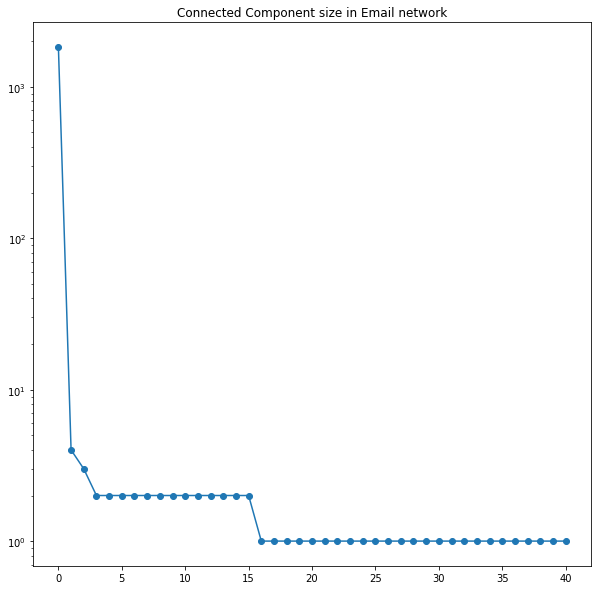

In [6]:
plt.figure(figsize=(10,10))
plt.title("Connected Component size in Email network")
plt.yscale('log')
plt.plot(ccSize, marker='o')
plt.show()

## Egonet analysis of top N nodes 

    1. Nodes ranked based on social score... 
    2. Nodes picked by CELF

In [7]:
#
# Load CELF nodes 
#
topCELFNodes = list()
with open('../results/CELF population 100k runs.txt', 'r') as fd:
    print fd.readline()
    fd.readline()
    reader = csv.reader(fd, delimiter='\t')  
    for row in reader:
        #print row
        topCELFNodes.append(int(row[0]))

P_infect = 0.3 P_initial_infect = 0.001 Runs per marginal node = 100000



In [8]:
#
# Load Speedup nodes 
#
topSpeedupNodes = list()
with open('../results/Speedup_population_live_edge.txt', 'r') as fd:
    print fd.readline()
    fd.readline()
    reader = csv.reader(fd, delimiter='\t')  
    for row in reader:
        #print row
        topSpeedupNodes.append(int(row[0]))

P_infect = 0.3 P_initial_infect = 0.005 Runs per marginal node = 100000



In [9]:
#
# Load social score nodes 
#
socialNodes = list()
topN = min(len(topCELFNodes), len(topSpeedupNodes))

with open('socialScore_unpruned.txt', 'r') as fd:
    reader = csv.reader(fd, delimiter='\t')            
    for row in reader:
        #print row
        socialNodes.append((row[0], row[1]))  
        
topSocialNodes = [ int(node) for (node, _) in socialNodes[:topN]]

In [10]:
#
# Number of Social Nodes overlapping with Nodes selected by CELF
#
topCELFNodeSet = set(topCELFNodes)
topSocialNodeSet = set(topSocialNodes)
print topSocialNodes[:5]
print topCELFNodes[:5]

print "Number of nodes in common: %r (total:%r)" % (len(topSocialNodeSet.intersection(topCELFNodeSet)), len(topCELFNodeSet))

[1874, 1258, 999, 1669, 511]
[1874, 1669, 453, 1706, 1159]
Number of nodes in common: 25 (total:50)


In [11]:
#
# Number of Social Nodes overlapping with Nodes selected by Speedup CELF
#
topSpeedupNodeSet = set(topSpeedupNodes)
topSocialNodeSet = set(topSocialNodes)
print topSocialNodes[:5]
print topSpeedupNodes[:5]

print "Number of nodes in common: %r (total:%r)" % (len(topSocialNodeSet.intersection(topSpeedupNodeSet)), len(topSpeedupNodeSet))

[1874, 1258, 999, 1669, 511]
[1874, 1669, 453, 1144, 1159]
Number of nodes in common: 24 (total:40)


In [12]:
# 
# Compute Egnonet for top odes based on Social Score 
#
topSocialNodeEgonet= dict()
topSocialNodeEgoNetNodes = dict()

for i, node in enumerate(topSocialNodes):
    topSocialNodeEgonet[i] = nx.ego_graph(uGNx, node, radius=1, undirected=True)   
    #
    # Generate list of egonet Nodes for each social scode node 
    #
    topSocialNodeEgoNetNodes[i] = set(topSocialNodeEgonet[i].nodes)
       

In [13]:
topSocialNodeOverlap = list()
topSocialNodeUnion = list()
egoNetNodes = set()
for i in range(len(topSocialNodes)-1):
    common_nodes = topSocialNodeEgoNetNodes[i].intersection(topSocialNodeEgoNetNodes[i+1])
    min_nodes = min(len(topSocialNodeEgoNetNodes[i]), len(topSocialNodeEgoNetNodes[i+1]))
    frac = float(len(common_nodes))/float(min_nodes)
    topSocialNodeOverlap.append(frac)
    egoNetNodes = egoNetNodes.union(topSocialNodeEgoNetNodes[i])
    topSocialNodeUnion.append(len(egoNetNodes))

In [14]:
# 
# Compute Egnonet for top odes based on Social Score 
#
topCELFNodeEgoNet= dict()
topCELFNodeEgoNetNodes = dict()

for i, node in enumerate(topCELFNodes):
    topCELFNodeEgoNet[i] = nx.ego_graph(uGNx, node, radius=1, undirected=True)   
    #
    # Generate list of egonet Nodes for each social scode node 
    #
    topCELFNodeEgoNetNodes[i] = set(topCELFNodeEgoNet[i].nodes)
       

In [15]:
topCELFNodesOverlap = list()
topCELFNodeUnion = list()
egoNetNodes = set()

for i in range(len(topCELFNodes)-1):
    common_nodes = topCELFNodeEgoNetNodes[i].intersection(topCELFNodeEgoNetNodes[i+1])
    min_nodes = min(len(topCELFNodeEgoNetNodes[i]), len(topCELFNodeEgoNetNodes[i+1]))
    frac = float(len(common_nodes))/float(min_nodes)
    topCELFNodesOverlap.append(frac)
    egoNetNodes = egoNetNodes.union(topCELFNodeEgoNetNodes[i])
    topCELFNodeUnion.append(len(egoNetNodes))


In [16]:
# 
# Compute Egnonet for top nodes based on Social Score 
#
topSpeedupNodeEgoNet= dict()
topSpeedupNodeEgoNetNodes = dict()

for i, node in enumerate(topSpeedupNodes):
    topSpeedupNodeEgoNet[i] = nx.ego_graph(uGNx, node, radius=1, undirected=True)   
    #
    # Generate list of egonet Nodes for each social scode node 
    #
    topSpeedupNodeEgoNetNodes[i] = set(topSpeedupNodeEgoNet[i].nodes)
       

In [17]:
print "Egonet size of node 1 picked by Speedup %r" % len(topSpeedupNodeEgoNetNodes[0])
print "Egonet size of node 1 picked by CELF %r" % len(topCELFNodeEgoNetNodes[0])
print "Egonet size of node 1 picked by Social Score ranking %r" %len(topSocialNodeEgoNetNodes[0])
print 
print "Egonet size of node %d picked by Speedup %r" % (topN, len(topSpeedupNodeEgoNetNodes[topN-1]))
print "Egonet size of node %d picked by CELF %r" % (topN, len(topCELFNodeEgoNetNodes[topN-1]))
print "Egonet size of node %d picked by Social Score ranking %r" % (topN, len(topSocialNodeEgoNetNodes[topN-1]))

Egonet size of node 1 picked by Speedup 403
Egonet size of node 1 picked by CELF 403
Egonet size of node 1 picked by Social Score ranking 403

Egonet size of node 40 picked by Speedup 4
Egonet size of node 40 picked by CELF 32
Egonet size of node 40 picked by Social Score ranking 55


In [18]:
topSpeedupNodesOverlap = list()
topSpeedupNodeUnion = list()
egoNetNodes = set()

for i in range(len(topSpeedupNodes)-1):
    common_nodes = topSpeedupNodeEgoNetNodes[i].intersection(topSpeedupNodeEgoNetNodes[i+1])
    min_nodes = min(len(topSpeedupNodeEgoNetNodes[i]), len(topSpeedupNodeEgoNetNodes[i+1]))
    frac = float(len(common_nodes))/float(min_nodes)
    topSpeedupNodesOverlap.append(frac)
    egoNetNodes = egoNetNodes.union(topSpeedupNodeEgoNetNodes[i])
    topSpeedupNodeUnion.append(len(egoNetNodes))


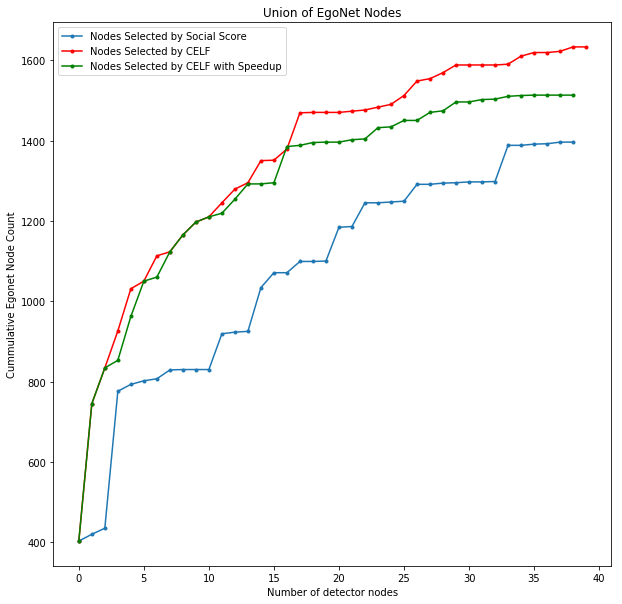

In [20]:
plt.figure(figsize=(10,10))
plt.title("Union of EgoNet Nodes")
plt.plot(topSocialNodeUnion, marker='.')
plt.plot(topCELFNodeUnion[:topN], 'r', marker='.')
plt.plot(topSpeedupNodeUnion, 'g', marker='.')
plt.xlabel('Number of detector nodes')
plt.ylabel('Cummulative Egonet Node Count')
plt.legend(['Nodes Selected by Social Score','Nodes Selected by CELF', 'Nodes Selected by CELF with Speedup'])
plt.show()

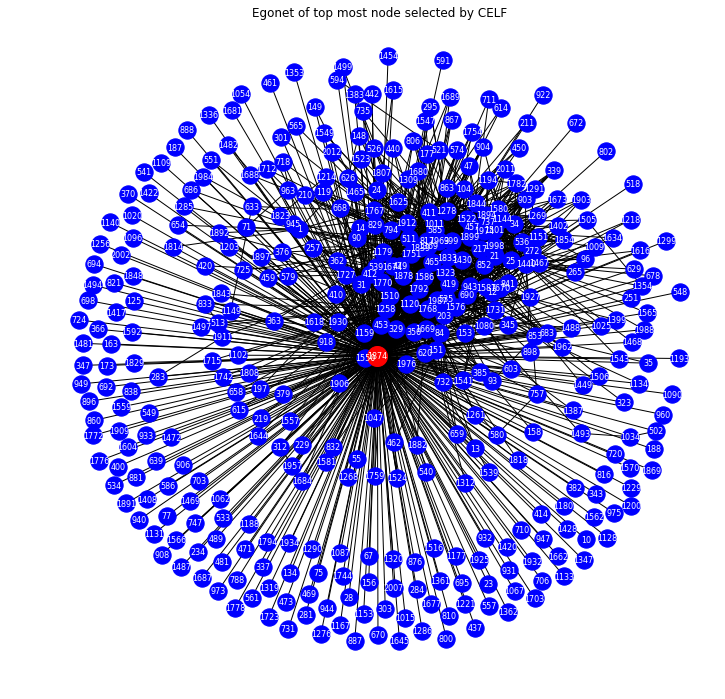

In [45]:
# Draw graph

plt.figure(figsize=(12,12))
plt.title("Egonet of top most node selected by CELF")
limits=plt.axis('off')
pos = nx.spring_layout(topCELFNodeEgoNet[0])
nx.draw_networkx(topCELFNodeEgoNet[0], pos, node_color='b', with_labels=True, font_size=8, font_color='w')
nx.draw_networkx_nodes(topCELFNodeEgoNet[0], pos, nodelist=[1874], node_size=400, node_color='r', font_color='black')
plt.show()



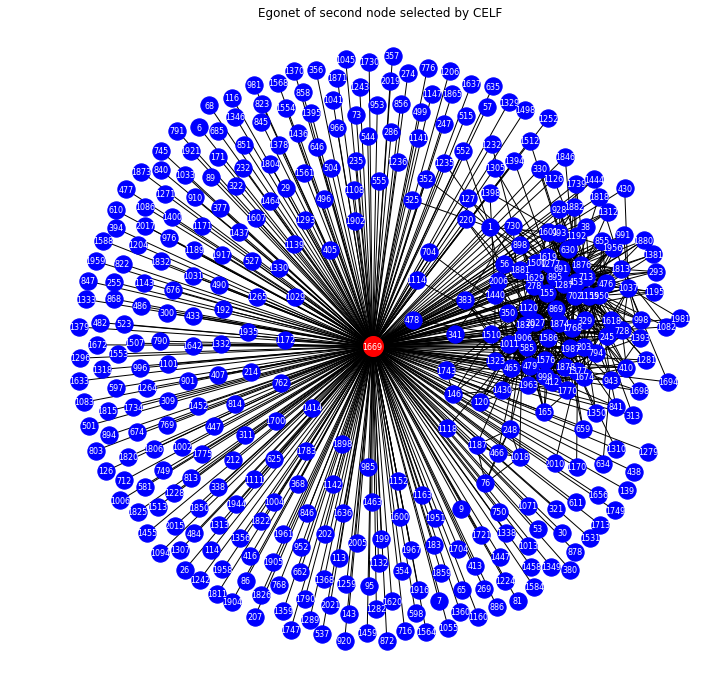

In [47]:
# Draw graph

plt.figure(figsize=(12,12))
plt.title("Egonet of second node selected by CELF")
limits=plt.axis('off')
pos = nx.spring_layout(topCELFNodeEgoNet[1])
nx.draw_networkx(topCELFNodeEgoNet[1], pos, node_color='b', with_labels=True, font_size=8, font_color='w')
nx.draw_networkx_nodes(topCELFNodeEgoNet[1], pos, nodelist=[topCELFNodes[1]], node_size=400, node_color='r', font_color='black')
plt.show()


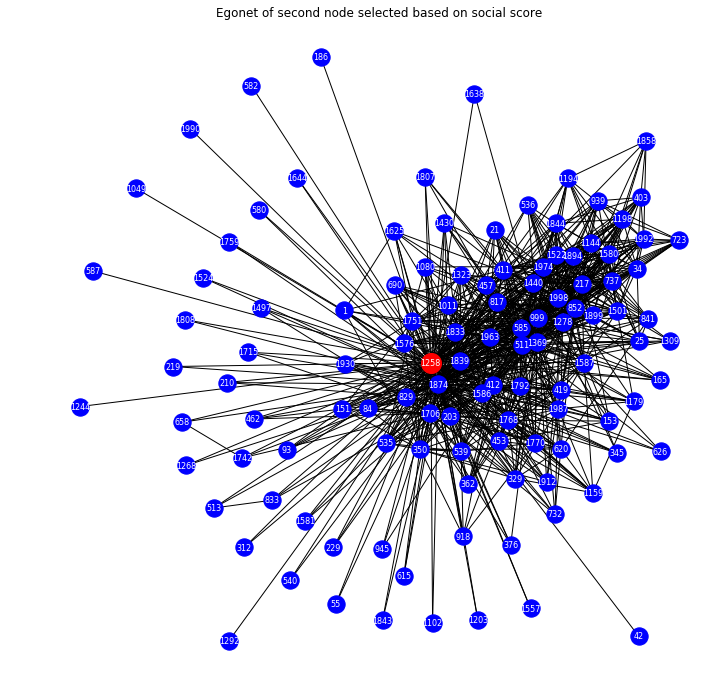

Egonet size of second node picked by Social Score: 116


In [49]:
# Draw graph

plt.figure(figsize=(12,12))
plt.title("Egonet of second node selected based on social score")
limits=plt.axis('off')
pos = nx.spring_layout(topSocialNodeEgonet[1], iterations=100)
nx.draw_networkx(topSocialNodeEgonet[1], pos, node_color='b', with_labels=True, font_size=8, font_color='w')
nx.draw_networkx_nodes(topSocialNodeEgonet[1], pos, nodelist=[topSocialNodes[1]], node_size=400, node_color='r', font_color='black')
plt.show()
print "Egonet size of second node picked by Social Score: %d" % len(topSocialNodeEgoNetNodes[1])

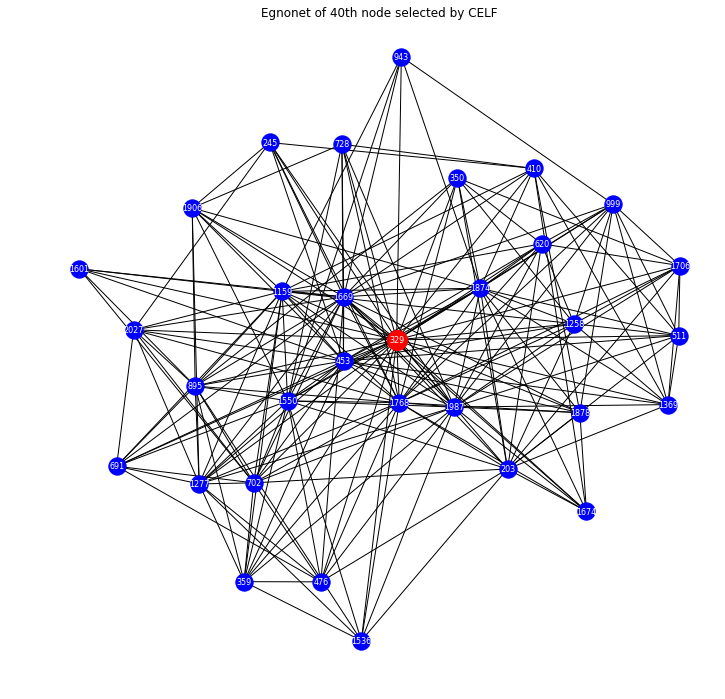

Egonet Size of 40 node picked by CELF = 32


In [54]:
#
# Plot EgoNet of last node in top N Nodes ranked by social score 
#
plt.figure(figsize=(12,12))
plt.title("Egnonet of %rth node selected by CELF" % (topN))
limits=plt.axis('off')
pos = nx.spring_layout(topCELFNodeEgoNet[topN-1], iterations=100)
nx.draw_networkx(topCELFNodeEgoNet[topN-1], pos, node_color='b', with_labels=True, font_size=8, font_color='w')
# Draw ego as large and red
nx.draw_networkx_nodes(topCELFNodeEgoNet[0], pos, nodelist=[topCELFNodes[topN-1]], node_size=400, node_color='r')
plt.show()
print "Egonet Size of %d node picked by CELF = %r" % (topN, len(topCELFNodeEgoNetNodes[topN-1]))

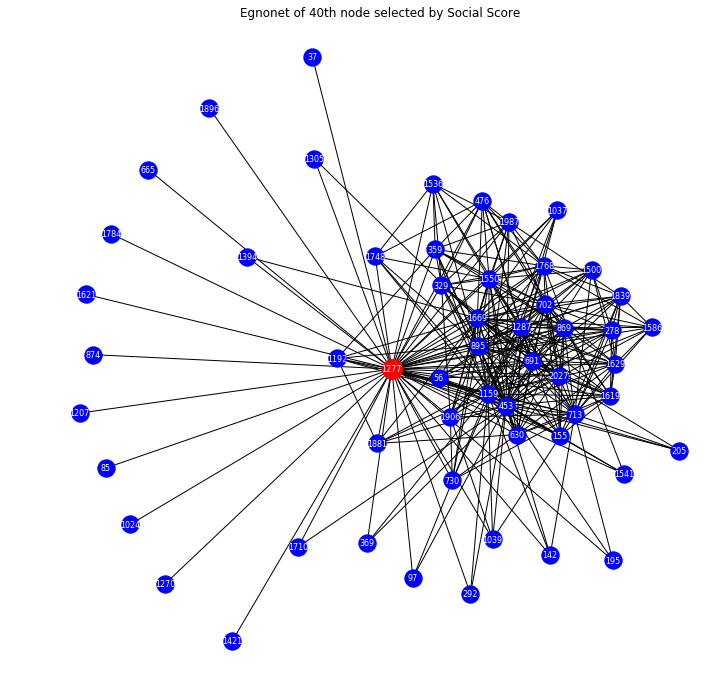

Egonet Size of 40 node picked by CELF = 55


In [59]:
#
# Plot EgoNet of last node in top N Nodes ranked by social score 
#
plt.figure(figsize=(12,12))
plt.title("Egnonet of %rth node selected by Social Score" % (topN))
limits=plt.axis('off')
pos = nx.spring_layout(topSocialNodeEgonet[topN-1], iterations=100)
nx.draw_networkx(topSocialNodeEgonet[topN-1], pos, node_color='b', with_labels=True, font_size=8, font_color='w')
# Draw ego as large and red
nx.draw_networkx_nodes(topSocialNodeEgonet[0], pos, nodelist=[topSocialNodes[topN-1]], node_size=400, node_color='r')
plt.show()
print "Egonet Size of %d node picked by CELF = %r" % (topN, len(topSocialNodeEgoNetNodes[topN-1]))

## k-core decomposition 

Analyze DNC email network. Identify central nodes in the network based on k-core decomposition 


Number of nodes in k=16 k-Core network: 51


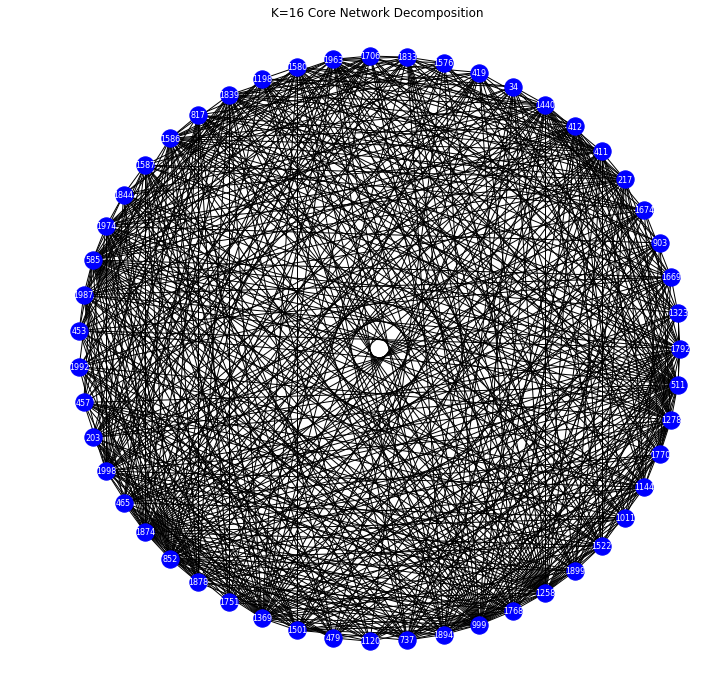

Average Clustering coefficient of k-core network: 0.7095142487861846


In [60]:
k = 16
uGNx.remove_edges_from(nx.selfloop_edges(uGNx))
k_core_graph = nx.k_core(uGNx, k=k)
print "Number of nodes in k=%d k-Core network: %d" % (k, nx.number_of_nodes(k_core_graph))
plt.figure(figsize=(12,12))
limits=plt.axis('off')
plt.title("K=16 Core Network Decomposition ")
nx.draw_circular(k_core_graph, node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()
print "Average Clustering coefficient of k-core network: %r" %(nx.average_clustering(k_core_graph))

In [64]:
k_core_nodes = list(k_core_graph.nodes)
k_core_node_set = set(k_core_nodes)
k_core_n_celf = topCELFNodeSet.intersection(k_core_node_set)
print "k=16 core network has %d nodes. %d nodes selected by CELF are in Core network" % (len(k_core_nodes),\
                                                                                               len(k_core_n_celf))
print "CELF Nodes not in k-core: %r" % (topCELFNodeSet - k_core_node_set)
print "Top CELF nodes in k-16 Core network: %r" % (k_core_n_celf)

k=16 core network has 51 nodes. 24 nodes selected by CELF are in Core network
CELF Nodes not in k-core: set([1, 390, 1159, 278, 24, 329, 1952, 547, 1287, 691, 713, 829, 993, 841, 1876, 1500, 350, 869, 1377, 1510, 1254, 1906, 246, 1274, 1151, 895])
Top CELF nodes in k-16 Core network: set([1792, 1669, 411, 412, 1440, 419, 1706, 1963, 1198, 1839, 1586, 453, 203, 1998, 465, 1874, 852, 1369, 999, 1768, 1258, 1144, 1278, 511])


In [65]:
k_core_nodes = list(k_core_graph.nodes)
k_core_node_set = set(k_core_nodes)
k_core_n_speedup = topSpeedupNodeSet.intersection(k_core_node_set)
print "k=16 core network has %d nodes. %d nodes selected by Speedup are in Core network" % (len(k_core_nodes),\
                                                                                               len(k_core_n_speedup))
print "Speedup Nodes not in k-core: %r" % (topSpeedupNodeSet - k_core_node_set)
print "Top Speedup nodes in k-16 Core network: %r" % (k_core_n_speedup)

k=16 core network has 51 nodes. 24 nodes selected by Speedup are in Core network
Speedup Nodes not in k-core: set([1, 547, 869, 1287, 808, 329, 1159, 1377, 993, 1906, 691, 1876, 278, 713, 350, 895])
Top Speedup nodes in k-16 Core network: set([1792, 1669, 217, 411, 412, 1440, 1706, 1198, 1839, 817, 1587, 1987, 453, 203, 1998, 465, 1874, 1369, 999, 1768, 1258, 1144, 1278, 511])


In [66]:
k_core_nodes = list(k_core_graph.nodes)
k_core_node_set = set(k_core_nodes)
k_core_n_social = topSocialNodeSet.intersection(k_core_node_set)
print "k=16 core network has %d nodes. %d nodes selected by Social Score are in Core network" % (len(k_core_nodes),\
                                                                                               len(k_core_n_social))
print "Social Score Nodes not in k-core: %r" % (topSocialNodeSet - k_core_node_set)
print "Top Social Score nodes in k-16 Core network: %r" % (k_core_n_social)

k=16 core network has 51 nodes. 32 nodes selected by Social Score are in Core network
Social Score Nodes not in k-core: set([480, 1, 1287, 1159, 301, 1753, 1277, 895])
Top Social Score nodes in k-16 Core network: set([1792, 1669, 1369, 411, 412, 1440, 34, 1833, 1706, 1963, 1580, 1198, 1839, 1586, 1974, 1987, 453, 585, 1998, 1874, 852, 217, 1501, 737, 1894, 999, 1768, 1258, 1522, 1144, 1278, 511])


In [67]:
socialNodeEgoNetDistribution = list()
totalEgoNetSize = 0.0
for i in range(topN):
    egoNetSize = len(list(topSocialNodeEgonet[i].nodes))
    socialNodeEgoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    
avgEgoNetSize = totalEgoNetSize/topN
print "Average Egonet size for top %d Social Score Nodes: %r, (Max:%r, min:%r)" % \
(topN, avgEgoNetSize, max(socialNodeEgoNetDistribution), min(socialNodeEgoNetDistribution))


Average Egonet size for top 40 Social Score Nodes: 86.05, (Max:403, min:3)


In [68]:
CELFNodeEgoNetDistribution = list()
totalEgoNetSize = 0.0
for i in range(topN):
    egoNetSize = len(list(topCELFNodeEgoNet[i].nodes))
    CELFNodeEgoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    
avgEgoNetSize = totalEgoNetSize/topN
print "Average Egonet size for top %d CELF Nodes: %r, (Max:%r, min:%r)" % \
(topN, avgEgoNetSize, max(CELFNodeEgoNetDistribution), min(CELFNodeEgoNetDistribution))

Average Egonet size for top 40 CELF Nodes: 83.95, (Max:403, min:10)


In [69]:
speedupNodeEgoNetDistribution = list()
totalEgoNetSize = 0.0
for i in range(topN):
    egoNetSize = len(list(topSpeedupNodeEgoNet[i].nodes))
    speedupNodeEgoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    
avgEgoNetSize = totalEgoNetSize/topN
print "Average Egonet size for top %d Speedup Nodes: %r, (Max:%r, min:%r)" % \
(topN, avgEgoNetSize, max(speedupNodeEgoNetDistribution), min(speedupNodeEgoNetDistribution))

Average Egonet size for top 40 Speedup Nodes: 85.075, (Max:403, min:4)


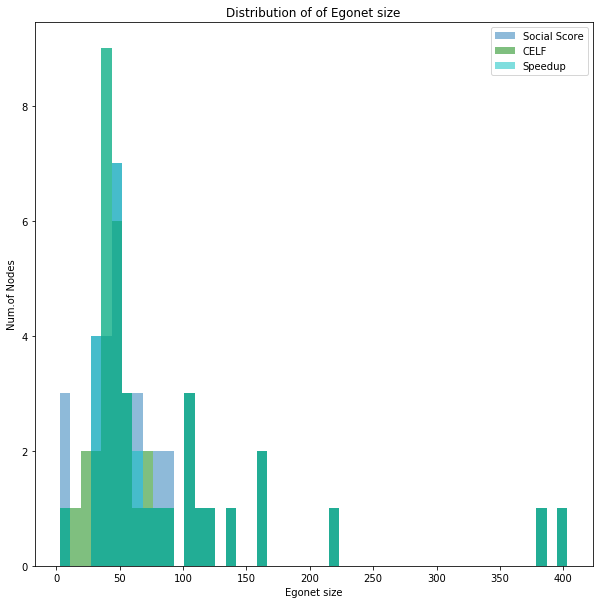

In [73]:
plt.figure(figsize=(10,10))
#plt.yscale('linear')
plt.title("Distribution of of Egonet size")
plt.xlabel('Egonet size')
plt.ylabel('Num.of Nodes')
#plt.vlines(avgEgoNetSize, 0, 9, color='r')
min_x = min(min(socialNodeEgoNetDistribution), min(CELFNodeEgoNetDistribution))
max_x = max(max(socialNodeEgoNetDistribution), max(CELFNodeEgoNetDistribution))
bins = np.linspace(min_x, max_x, 50)

plt.hist(socialNodeEgoNetDistribution, bins, alpha=0.5, label='SocialScore')
plt.hist(CELFNodeEgoNetDistribution, bins, alpha=0.5, label='CELF', color='g')
plt.hist(speedupNodeEgoNetDistribution, bins, alpha=0.5, label='CELF', color='c')
plt.legend(['Social Score', 'CELF', 'Speedup'])
plt.show()

## Betweeness centrality

In [92]:
node_between_centrality = nx.betweenness_centrality(uGNx)


In [120]:
celfNodeBetweenCentrality = list()

totalCelfNodeBetweenCentrality = 0.0

for i, n in enumerate(topCELFNodes):   
    b = node_between_centrality.get(n, None)
    
    if b == None:
        print "Node %r not found in pruned Graph!" % n
        continue
        
    celfNodeBetweenCentrality.append(b)
    totalCelfNodeBetweenCentrality += b    

avgCelfNodeBetweenCentrality = totalCelfNodeBetweenCentrality/len(topCELFNodes)  
print "Average Betweeness Centrality of nodes selected by CELF: %r" % avgCelfNodeBetweenCentrality

Average Betweeness Centrality of nodes selected by CELF: 0.03574838478480722


In [121]:
socialNodeBetweenCentrality = list()

totalSocialNodeBetweenCentrality = 0.0

for i, n in enumerate(topSocialNodes):   
    b = node_between_centrality.get(n, None)
    
    if b == None:
        print "Node %r not found in pruned Graph!" % n
        continue
        
    socialNodeBetweenCentrality.append(b)
    totalSocialNodeBetweenCentrality += b    

avgSocialNodeBetweenCentrality = totalSocialNodeBetweenCentrality/len(topSocialNodes)  
print "Average Betweeness Centrality of nodes selected by Social Score: %r" % avgSocialNodeBetweenCentrality

Average Betweeness Centrality of nodes selected by Social Score: 0.03174615837507464


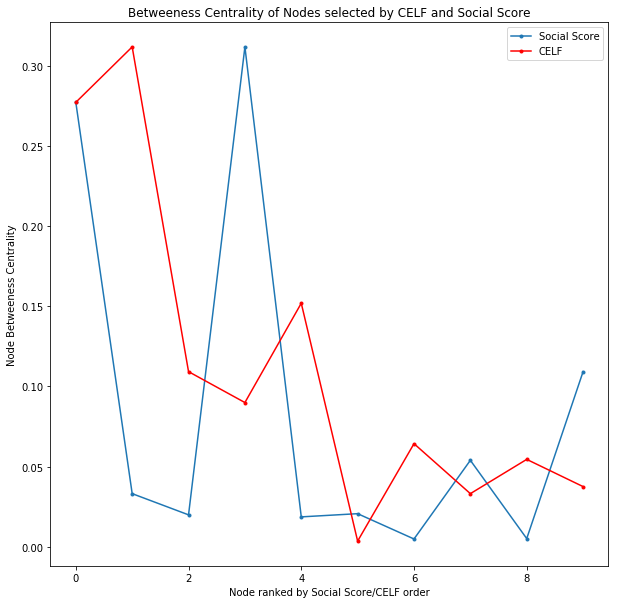

In [260]:
plt.figure(figsize=(10,10))
plt.title("Betweeness Centrality of Nodes selected by CELF and Social Score")
plt.ylabel("Node Betweeness Centrality")
plt.xlabel("Node ranked by Social Score/CELF order")
plt.plot(socialNodeBetweenCentrality[:10], marker='.')
plt.plot(celfNodeBetweenCentrality[:10], 'r', marker='.')
plt.legend(['Social Score', 'CELF'])
plt.show()

In [261]:
pageRank = nx.pagerank(uGNx)
katzCentrality = nx.katz_centrality(uGNx, alpha=0.01)
nk_list = [(node, v) for node, v in katzCentrality.iteritems()]
nk_list.sort(key=lambda x: x[1], reverse=True)
print nk_list[:20]

np_list = [(node, v) for node, v in pageRank.iteritems()]
np_list.sort(key=lambda x: x[1], reverse=True)
print np_list[:20]

[(1874, 0.12224340850952838), (1669, 0.11311546428675916), (1159, 0.07474923364706863), (453, 0.06436541618987239), (1706, 0.061511979122706985), (1839, 0.05955793150341195), (1258, 0.05678960129264774), (999, 0.05484480332582227), (511, 0.054362326837339284), (585, 0.0500378785247802), (1, 0.04929806409749608), (1287, 0.048037342818758724), (1440, 0.04721687275780671), (1369, 0.04570098788941142), (737, 0.04453589874223503), (1768, 0.042479695328786614), (895, 0.04239088387696494), (852, 0.0421476231576861), (1998, 0.04185679256632476), (1586, 0.041506947643602285)]
[(1669, 0.05755745012999271), (1874, 0.04159278450515554), (1159, 0.02751489621770259), (1, 0.020540383510953362), (1706, 0.019432217723940794), (453, 0.016552829736588014), (246, 0.012522780885635099), (1287, 0.012351246055221726), (1839, 0.011118654478453914), (895, 0.009487119062647252), (1258, 0.008586083926328819), (993, 0.007903312458670297), (1274, 0.007627648545566611), (511, 0.007473262587423167), (1440, 0.0072828

In [262]:
#
# Plot Katz, Pagerank and Betweeness Centrality of top nodes picked by CELF 
#

topSocial_katz= [katzCentrality[nn] for nn in topSocialNodes ]
topSocial_pageRank = [pageRank[nn] for nn in topSocialNodes ]
topSocial_betweeness = [node_between_centrality[nn] for nn in topSocialNodes ]

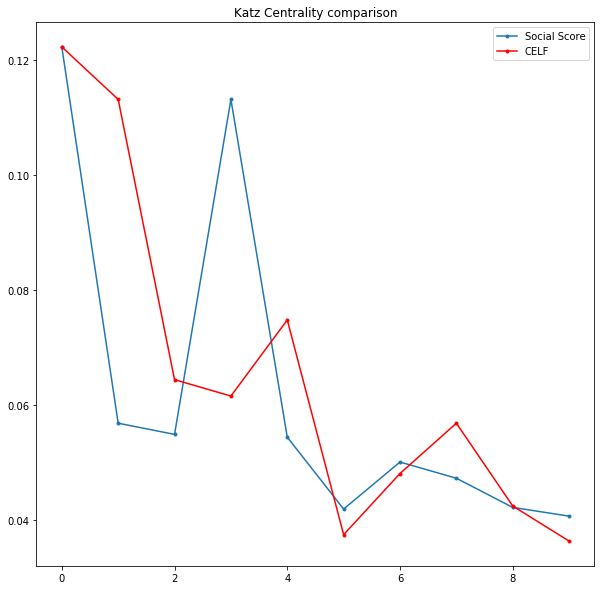

In [263]:
plt.figure(figsize=(10,10))
plt.title("Katz Centrality comparison")
plt.plot(topSocial_katz[:10], marker='.')
plt.plot(topCELF_katz[:10], 'r', marker='.')
plt.legend(['Social Score', 'CELF'])
plt.show()

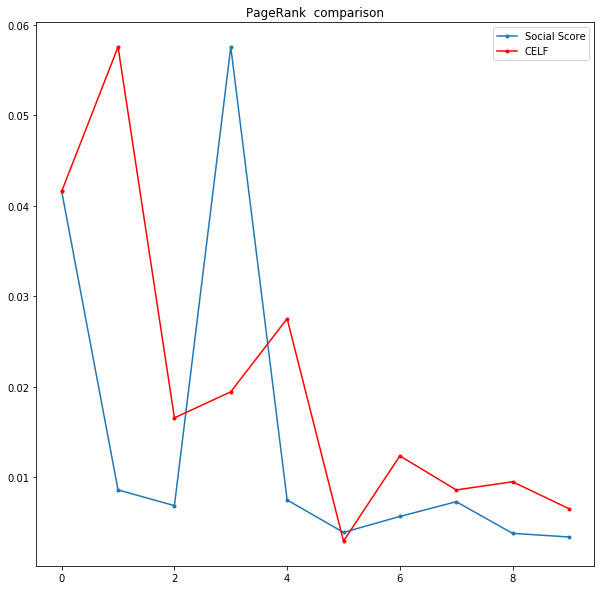

In [264]:
plt.figure(figsize=(10,10))
plt.title("PageRank  comparison")
plt.plot(topSocial_pageRank[:10], marker='.')
plt.plot(topCELF_pageRank[:10], 'r', marker='.')
plt.legend(['Social Score', 'CELF'])
plt.show()

In [265]:
harmonicCentrality = nx.harmonic_centrality(uGNx)
nh_list = [(node, v) for node, v in harmonicCentrality.iteritems()]
nh_list.sort(key=lambda x: x[1], reverse=True)
print nh_list[:20]

[(1669, 1037.2833333333376), (1874, 1023.7166666666739), (1159, 924.0833333333397), (453, 923.1666666666708), (1839, 855.3333333333404), (1, 840.2166666666723), (1768, 833.9000000000049), (585, 832.3833333333394), (1906, 831.3666666666721), (1258, 825.3833333333392), (1586, 824.5500000000053), (999, 819.4500000000058), (1287, 818.9333333333403), (329, 815.1666666666722), (1987, 815.1333333333387), (1550, 807.5333333333398), (412, 803.3500000000063), (511, 793.3833333333406), (1120, 792.9666666666726), (350, 792.9333333333384)]


In [266]:
topSocial_harmonicCentrality = [harmonicCentrality[nn] for nn in topSocialNodes ]
topCELF_harmonicCentrality = [harmonicCentrality[nn] for nn in topCELFNodes ]

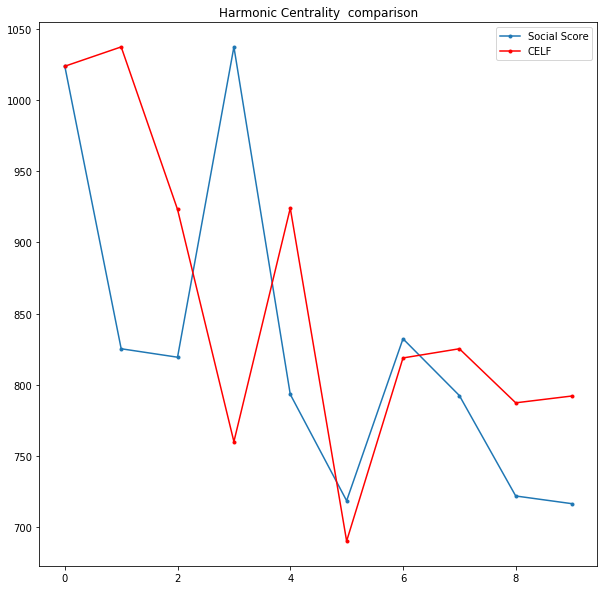

In [267]:
plt.figure(figsize=(10,10))
plt.title("Harmonic Centrality  comparison")
plt.plot(topSocial_harmonicCentrality[:10], marker='.')
plt.plot(topCELF_harmonicCentrality[:10], 'r', marker='.')
plt.legend(['Social Score', 'CELF'])
plt.show()

## Curve Fitting... 

In [268]:
#
# Page rank curve fit 
# 

def func(x, a, b, c):
    return a * np.exp(-b * x)  + c
xdata = [float(i) for i in range(10)]
popt, pcov = optimize.curve_fit(func, xdata, topSocial_pageRank[:10])
popt2, pcov2 = optimize.curve_fit(func, xdata, topCELF_pageRank[:10])
print popt

[2.99857185e-02 1.91855173e+01 1.16070659e-02]


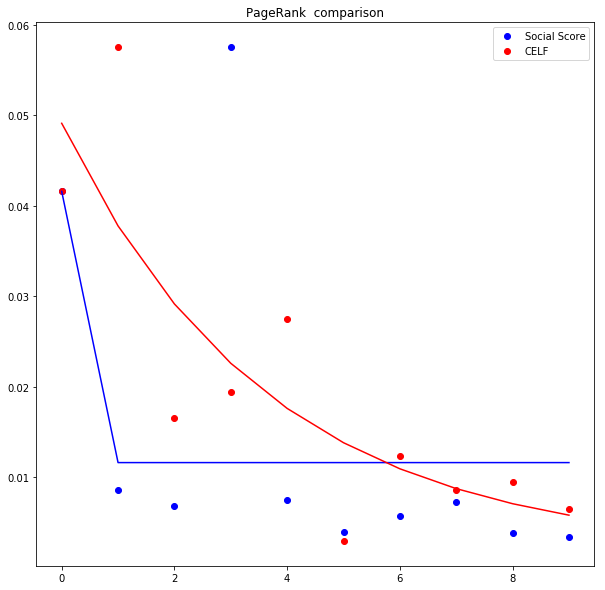

In [269]:
plt.figure(figsize=(10,10))
plt.title("PageRank  comparison")
plt.plot(topSocial_pageRank[:10], 'bo')
plt.plot(topCELF_pageRank[:10], 'ro')
plt.plot(xdata, func(np.asarray(xdata), *popt), 'b')
plt.plot(xdata, func(np.asarray(xdata), *popt2), 'r')
plt.legend(['Social Score', 'CELF'])
plt.show()

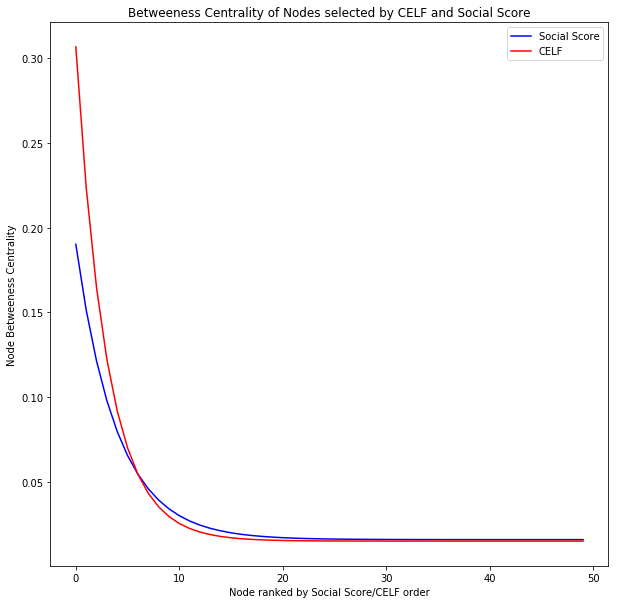

In [270]:
#
# Betweeness curve fit... 
#

def func(x, a, b, c):
    return a * np.exp(-b * x)  + c
xdata = [float(i) for i in range(topN)]
popt, pcov = optimize.curve_fit(func, xdata, socialNodeBetweenCentrality)
popt2, pcov2 = optimize.curve_fit(func, xdata, celfNodeBetweenCentrality)

plt.figure(figsize=(10,10))
plt.title("Betweeness Centrality of Nodes selected by CELF and Social Score")
plt.ylabel("Node Betweeness Centrality")
plt.xlabel("Node ranked by Social Score/CELF order")
#plt.plot(socialNodeBetweenCentrality, 'bo')
#plt.plot(celfNodeBetweenCentrality, 'ro')
plt.plot(xdata, func(np.asarray(xdata), *popt), 'b')
plt.plot(xdata, func(np.asarray(xdata), *popt2), 'r')
plt.legend(['Social Score', 'CELF'])
plt.show()

In [271]:
celfSelected = topCELFNodeSet - topSocialNodeSet

[12, 14, 16, 20, 23, 24, 27, 28, 29, 34, 35, 36, 38, 39, 40, 43, 44, 47, 48]
Nodes CELF picked that aren't in top 50 Social Score set 
[1274, 246, 1377, 1151, 350, 1876, 691, 1906, 547, 1254, 390, 419, 1952, 329, 1510, 1500, 829, 841, 24]


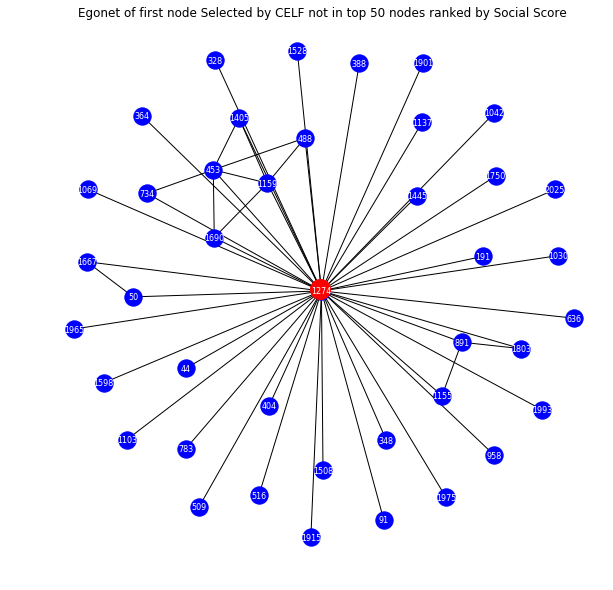

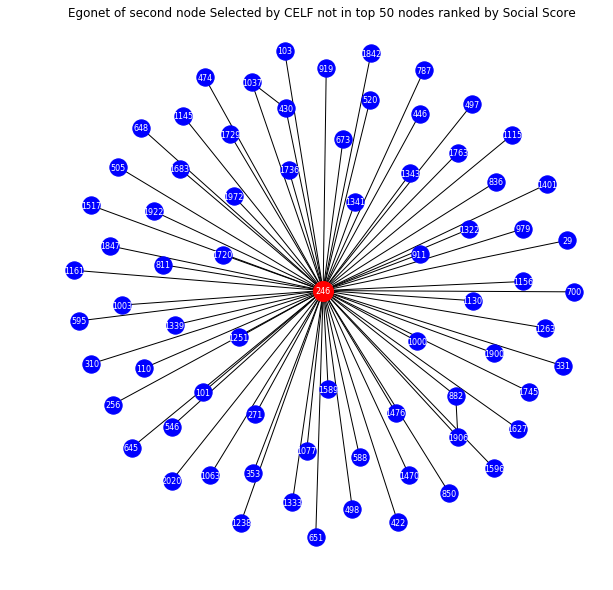

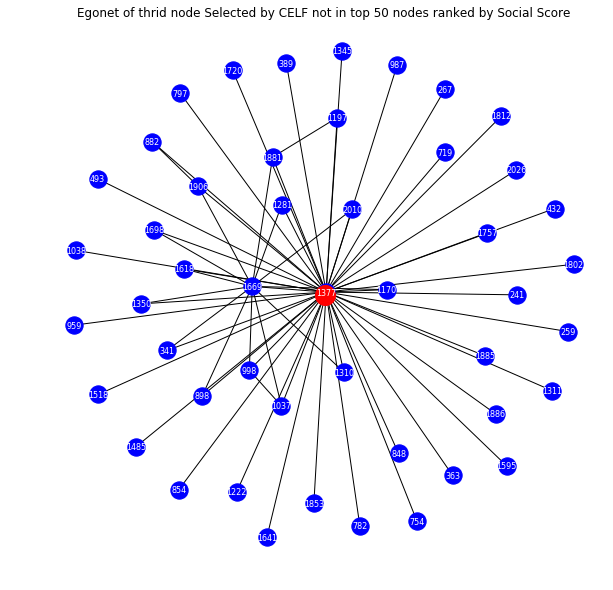

In [588]:
celfOnlyNodes = list()
for n in celfSelected:
    i = topCELFNodes.index(n)
    celfOnlyNodes.append(i)

celfOnlyNodes.sort()
print celfOnlyNodes

#nx.draw_networkx(topCELFNodeEgoNet[i], node_color='b', with_labels=True, font_size=8, font_color='w')
print "Nodes CELF picked that aren't in top 50 Social Score set \n%r" % [topCELFNodes[i] for i in celfOnlyNodes]

plt.figure(figsize=(10,10))
limits=plt.axis('off')
plt.title("Egonet of first node Selected by CELF not in top 50 nodes ranked by Social Score ")
pos = nx.spring_layout(topCELFNodeEgoNet[celfOnlyNodes[0]], iterations=100)
nx.draw_networkx(topCELFNodeEgoNet[celfOnlyNodes[0]], node_color='b', with_labels=True, font_size=8, font_color='w')
nx.draw_networkx_nodes(topCELFNodeEgoNet[celfOnlyNodes[0]], pos, nodelist=[topCELFNodes[celfOnlyNodes[0]]], node_size=400, node_color='r', font_color='black')
plt.show()

plt.figure(figsize=(10,10))
limits=plt.axis('off')
pos = nx.spring_layout(topCELFNodeEgoNet[celfOnlyNodes[1]], iterations=100)
plt.title("Egonet of second node Selected by CELF not in top 50 nodes ranked by Social Score ")
nx.draw_networkx(topCELFNodeEgoNet[celfOnlyNodes[1]], node_color='b', with_labels=True, font_size=8, font_color='w')
nx.draw_networkx_nodes(topCELFNodeEgoNet[celfOnlyNodes[1]], pos, nodelist=[topCELFNodes[celfOnlyNodes[1]]], node_size=400, node_color='r', font_color='black')
plt.show()

plt.figure(figsize=(10,10))
limits=plt.axis('off')
plt.title("Egonet of thrid node Selected by CELF not in top 50 nodes ranked by Social Score")
pos = nx.spring_layout(topCELFNodeEgoNet[celfOnlyNodes[2]], iterations=100)
nx.draw_networkx(topCELFNodeEgoNet[celfOnlyNodes[2]], node_color='b', with_labels=True, font_size=8, font_color='w')
nx.draw_networkx_nodes(topCELFNodeEgoNet[celfOnlyNodes[2]], pos, nodelist=[topCELFNodes[celfOnlyNodes[2]]], node_size=400, node_color='r', font_color='black')
plt.show()

In [273]:
#
# Print order in which CELF selected Social Score nodes 
celfOrder = list()
for n in topCELFNodes:
    if n not in topSocialNodes:
        continue
    celfOrder.append(topSocialNodes.index(n) + 1)
print "CELF picked top 50 Social Score nodes in following order: \n%r" % celfOrder

CELF picked top 50 Social Score nodes in following order: 
[1, 4, 12, 21, 15, 22, 23, 2, 27, 45, 3, 47, 5, 30, 34, 41, 42, 49, 29, 8, 16, 17, 28, 10, 14, 44, 24, 6, 9, 32, 26]


In [289]:
#
# Print Ranking of Nodes Selected by CELF that aren't in top N Social Score nodes 
#
celfOnlyOrder = list()
# Print order in which CELF selected Social Score nodes 

allNodes = [int(n) for n, v in socialNodes]
for i, n in enumerate(celfSelected):
    if n not in allNodes:
        continue
    celfOnlyOrder.append((celfOnlyNodes[i],(allNodes.index(n) + 1)))
    
print "CELF picked nodes not in top 50\n%r" % celfOnlyOrder


CELF picked nodes not in top 50
[(12, 963), (14, 68), (16, 72), (20, 163), (23, 134), (24, 1015), (27, 124), (28, 58), (29, 70), (34, 63), (35, 67), (36, 564), (38, 61), (39, 123), (40, 85), (43, 238), (44, 66), (47, 51), (48, 994)]


In [301]:
#
# Load social score nodes 
#
nodeFeatures = dict()

with open('../results/nodeSocialScoreFeature.txt', 'r') as fd:
    reader = csv.reader(fd, delimiter=',')            
    for row in reader:
        #print row
        nodeFeatures[row[0]] = [row[4], row[5], row[6] ] 
        

In [305]:
for i, n in enumerate(celfSelected):
    print "CELF Order: %d, Node: %d, #clique: %r, #rawClique: %r, weighted:%r" % \
        (celfOnlyNodes[i], n, nodeFeatures[str(n)][0], nodeFeatures[str(n)][1], nodeFeatures[str(n)][2])

CELF Order: 12, Node: 1952, #clique: '8', #rawClique: '40', weighted:'0.0'
CELF Order: 14, Node: 1377, #clique: '10', #rawClique: '56', weighted:'0.0'
CELF Order: 16, Node: 547, #clique: '8', #rawClique: '32', weighted:'0.0'
CELF Order: 20, Node: 390, #clique: '0.0', #rawClique: '0.0', weighted:'0.0'
CELF Order: 23, Node: 1510, #clique: '6', #rawClique: '164', weighted:'0.0'
CELF Order: 24, Node: 1254, #clique: '0.0', #rawClique: '0.0', weighted:'0.0'
CELF Order: 27, Node: 841, #clique: '8', #rawClique: '240', weighted:'0.0'
CELF Order: 28, Node: 419, #clique: '1', #rawClique: '8', weighted:'0.0'
CELF Order: 29, Node: 1906, #clique: '12', #rawClique: '148', weighted:'0.0'
CELF Order: 34, Node: 691, #clique: '21', #rawClique: '2360', weighted:'0.0'
CELF Order: 35, Node: 1876, #clique: '6', #rawClique: '120', weighted:'0.0'
CELF Order: 36, Node: 246, #clique: '8', #rawClique: '36', weighted:'0.0'
CELF Order: 38, Node: 329, #clique: '18', #rawClique: '464', weighted:'0.0'
CELF Order: 39, 

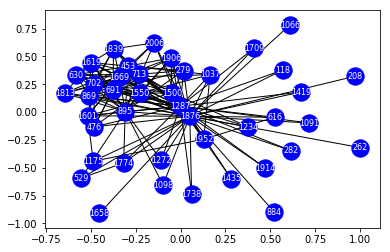

In [309]:
nx.draw_networkx(topCELFNodeEgoNet[celfOnlyNodes[5]], node_color='b', with_labels=True, font_size=8, font_color='w')

In [19]:
from networkx.algorithms.community import greedy_modularity_communities
scc_community = greedy_modularity_communities(SCC)

In [20]:
scc_comm_social_nodes = list()
scc_comm_celf_nodes = list()

for i, community in enumerate(scc_community):
    community_node_set = set(community)
    social_nodes_in_community = topSocialNodeSet.intersection(community_node_set)
    celf_nodes_in_community = topCELFNodeSet.intersection(community_node_set)
    print "Commuinity[%d] size: %d" % (i, len(community_node_set))
    #print "Social Score Nodes found in community[%d]: %d" % (i, len(social_nodes_in_community))
    scc_comm_social_nodes.append((i, len(social_nodes_in_community)))
    #print "CELF Nodes found in community[%d]: %d" % (i, len(celf_nodes_in_community))
    scc_comm_celf_nodes.append((i, len(celf_nodes_in_community)))

Commuinity[0] size: 442
Commuinity[1] size: 367
Commuinity[2] size: 323
Commuinity[3] size: 276
Commuinity[4] size: 226
Commuinity[5] size: 107
Commuinity[6] size: 38
Commuinity[7] size: 20
Commuinity[8] size: 5
Commuinity[9] size: 5
Commuinity[10] size: 4
Commuinity[11] size: 4
Commuinity[12] size: 4
Commuinity[13] size: 4
Commuinity[14] size: 3
Commuinity[15] size: 3
Commuinity[16] size: 2


In [21]:
socialNodeCommunity = list()

for n in topSocialNodes:
    for i, community in enumerate(scc_community):
        if n in community:
            socialNodeCommunity.append((n, i+1))
            
print "Social Node to community mapping:\n%r" % socialNodeCommunity[:20]

Social Node to community mapping:
[(1874, 2), (1258, 3), (999, 3), (1669, 4), (511, 3), (1998, 3), (585, 3), (1440, 3), (852, 3), (1278, 3), (1974, 3), (453, 1), (1580, 3), (411, 3), (1159, 1), (1839, 3), (1369, 3), (737, 3), (1894, 3), (1522, 3)]


In [23]:
celfNodeCommunity = list()

for n in topCELFNodes:
    for i, community in enumerate(scc_community):
        n = int(n)
        if n in community:
            celfNodeCommunity.append((n, i+1))          

print "CELF Node to community mapping:\n%r" % celfNodeCommunity[:20]

CELF Node to community mapping:
[(1874, 2), (1669, 4), (453, 1), (1706, 2), (1159, 1), (1144, 3), (1287, 1), (1258, 3), (895, 1), (278, 1), (999, 3), (993, 5), (1274, 7), (511, 3), (246, 5), (412, 3), (1377, 5), (1, 6), (465, 3), (203, 3)]


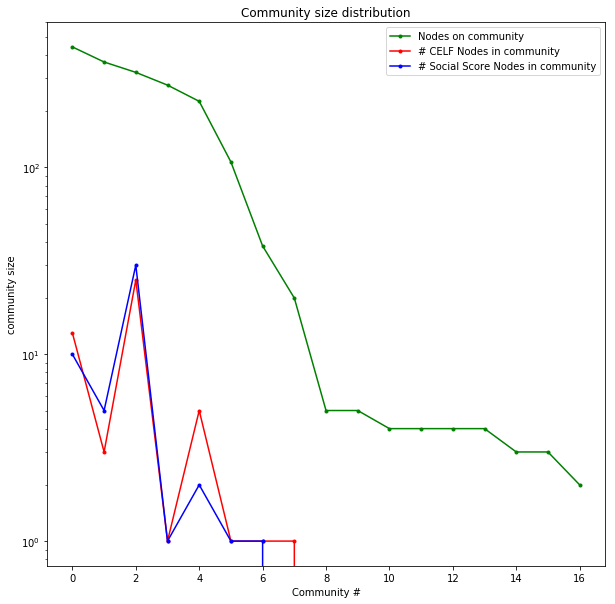

In [24]:
scc_community_size = [len(c) for c in scc_community]
yc = [s for i, s in scc_comm_celf_nodes]
ys = [s for i, s in scc_comm_social_nodes]

plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(scc_community_size, 'g', marker='.')
plt.plot(yc, 'r', marker='.')
plt.plot(ys, 'b', marker='.')
plt.legend(['Nodes on community',  '# CELF Nodes in community', '# Social Score Nodes in community'])
plt.xlabel('Community #')
plt.ylabel('community size')
plt.title("Community size distribution")
plt.show()

In [25]:
cmaps = ['blue', 'green', 'orange', 'red', 'purple', 'grey', 'brown', 'black']

egonet_size = [len(v) for k, v in topCELFNodeEgoNet.iteritems()]
minNodeSize = min(egonet_size)
maxNodeSize = max(egonet_size)

print minNodeSize, maxNodeSize

#
# Get EgoNets of CELF Nodes 
#
celfNodeEgonet = dict()
celfNodeMapColor = dict()
celfNodeSize = dict()
celfNodeCommunity.sort(key=lambda x: (x[1], [x[0]]))

for node, community in celfNodeCommunity:
    egoGraph = nx.ego_graph(uGNx, node, radius=1, undirected=True) 
    egonetNodeList = list(egoGraph.nodes())
    nodeSize = min(float(150)*((maxNodeSize + 1)/(len(egonetNodeList) - minNodeSize + 1)), 800)
    celfNodeEgonet[node] = egonetNodeList
    celfNodeSize[node] = nodeSize
    celfNodeMapColor[node] = cmaps[community-1]

    

10 403


In [26]:

celfGNx = nx.Graph()
for (src, _) in celfNodeCommunity:
    for (dst, _) in celfNodeCommunity:
        if src == dst:
            continue

        edge_count = uGNx.number_of_edges(src, dst)
        
        if edge_count > 0:
            celfGNx.add_edge(src, dst)
            pass

In [27]:
commDict = dict()

for n, c in celfNodeCommunity:
    if c not in commDict:
        commDict[c] = list()
    commDict[c].append(n)

shells = list()
for c, nodes in commDict.iteritems():
    shells.append(nodes)

print shells[:7]

[[278, 329, 453, 691, 713, 869, 895, 1159, 1287, 1500, 1768, 1876, 1906], [390, 1706, 1874], [24, 203, 350, 411, 412, 419, 465, 511, 829, 841, 852, 999, 1144, 1151, 1198, 1258, 1278, 1369, 1440, 1510, 1586, 1792, 1839, 1963, 1998], [1669], [246, 547, 993, 1377, 1952], [1], [1274]]


In [28]:
node_color = list()
node_size = list()
for node in celfGNx:
    node_color.append(celfNodeMapColor[node])
    node_size.append(celfNodeSize[node])

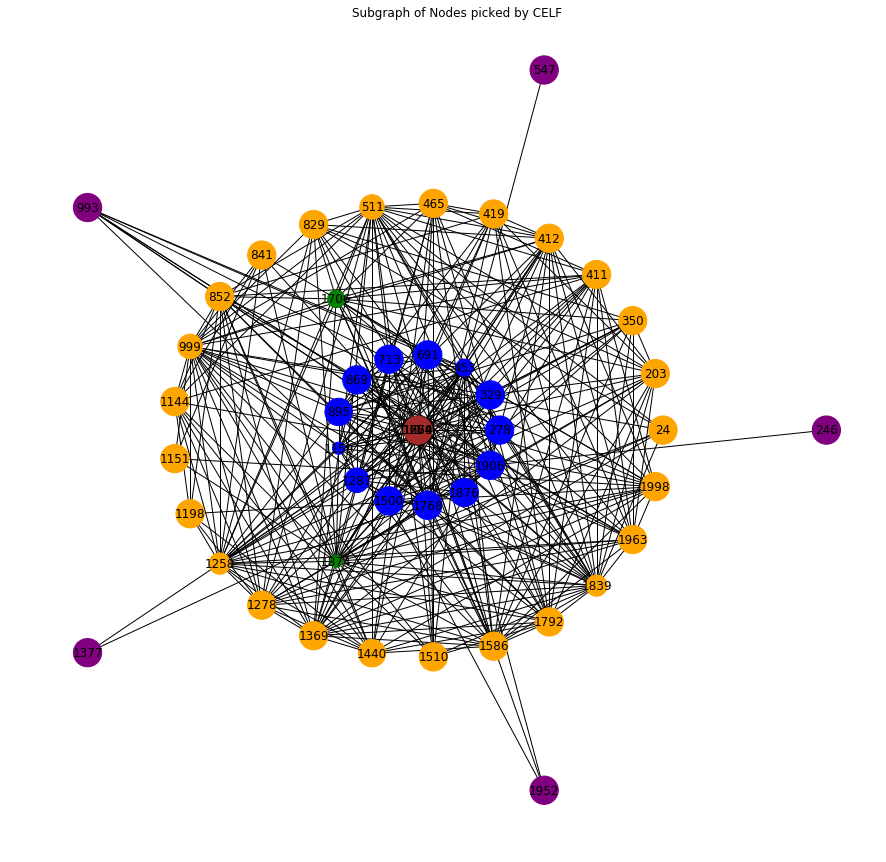

In [29]:
plt.figure(figsize=(15,15))
#pos=nx.spring_layout(celfGNx, iterations=500)
limits=plt.axis('off')
pos = nx.shell_layout(celfGNx, shells)
plt.title('Subgraph of Nodes picked by CELF')
nx.draw_networkx(celfGNx, pos=pos, node_size=node_size, node_color=node_color, with_labels=True)
plt.show()

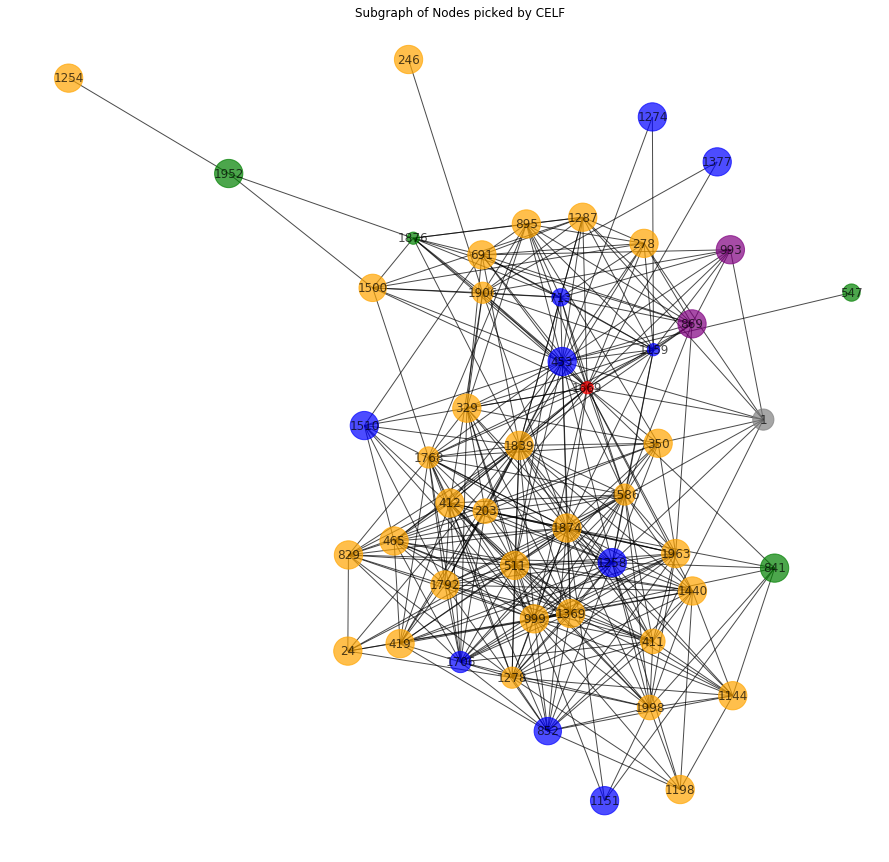

In [602]:

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

pos = graphviz_layout(celfGNx, prog='neato', args='')

plt.figure(figsize=(15, 15))
plt.title('Subgraph of Nodes picked by CELF')
limits=plt.axis('off')
nx.draw(celfGNx, pos, node_size=node_size, alpha=0.7, node_color=node_color, with_labels=True)
plt.axis('equal')
plt.show()

In [537]:
print "Average clustering of CELF node: %r" % nx.average_clustering(celfGNx)

Average clustering of CELF node: 0.6289460272945637


In [30]:
cmaps = ['blue', 'green', 'orange', 'red', 'purple', 'grey', 'brown', 'black']

s_egonet_size = [len(v) for k, v in topSocialNodeEgonet.iteritems()]
minNodeSize = min(s_egonet_size)
maxNodeSize = max(s_egonet_size)

print minNodeSize, maxNodeSize

#
# Get EgoNets of Social Nodes 
#
socialNodeEgonet = dict()
socialNodeMapColor = dict()
socialNodeSize = dict()
socialNodeCommunity.sort(key=lambda x: (x[1], [x[0]]))

for node, community in socialNodeCommunity:
    egoGraph = nx.ego_graph(uGNx, node, radius=1, undirected=True) 
    egonetNodeList = list(egoGraph.nodes())
    nodeSize = min(float(150)*((maxNodeSize + 1)/(len(egonetNodeList) - minNodeSize + 1)), 800)
    socialNodeEgonet[node] = egonetNodeList
    socialNodeSize[node] = nodeSize
    socialNodeMapColor[node] = cmaps[community-1]

    

2 403


In [31]:

socialGNx = nx.Graph()
for (src, _) in socialNodeCommunity:
    for (dst, _) in socialNodeCommunity:
        if src == dst:
            continue

        edge_count = uGNx.number_of_edges(src, dst)
        
        if edge_count > 0:
            socialGNx.add_edge(src, dst)
            pass

In [32]:
commDict = dict()

for n, c in socialNodeCommunity:
    if c not in commDict:
        commDict[c] = list()
    commDict[c].append(n)

shells = list()
for c, nodes in commDict.iteritems():
    shells.append(nodes)

print shells[:7]

[[278, 453, 713, 869, 895, 1159, 1277, 1287, 1768, 1987], [301, 984, 1706, 1753, 1874], [34, 203, 217, 411, 412, 465, 511, 585, 737, 852, 999, 1144, 1198, 1258, 1278, 1369, 1440, 1501, 1522, 1580, 1586, 1587, 1792, 1833, 1839, 1844, 1894, 1963, 1974, 1998], [1669], [480, 993], [1], [1301]]


In [33]:
node_color = list()
node_size = list()
for node in socialGNx:
    node_color.append(socialNodeMapColor[node])
    node_size.append(socialNodeSize[node])

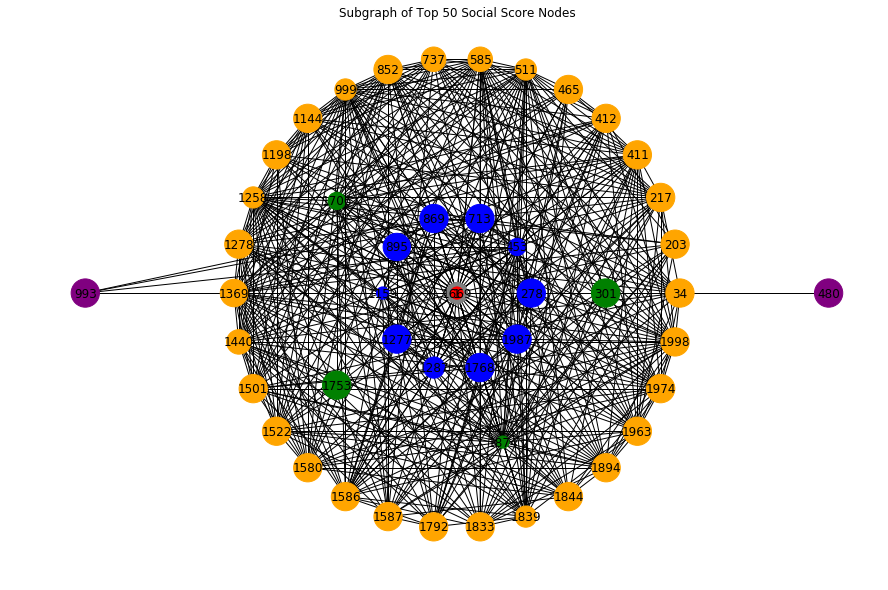

In [36]:
plt.figure(figsize=(15,10))
limits=plt.axis('off')
pos = nx.shell_layout(socialGNx, shells)
plt.title('Subgraph of Top 50 Social Score Nodes')
nx.draw_networkx(socialGNx, pos=pos, node_size=node_size, node_color=node_color, with_labels=True)
plt.show()

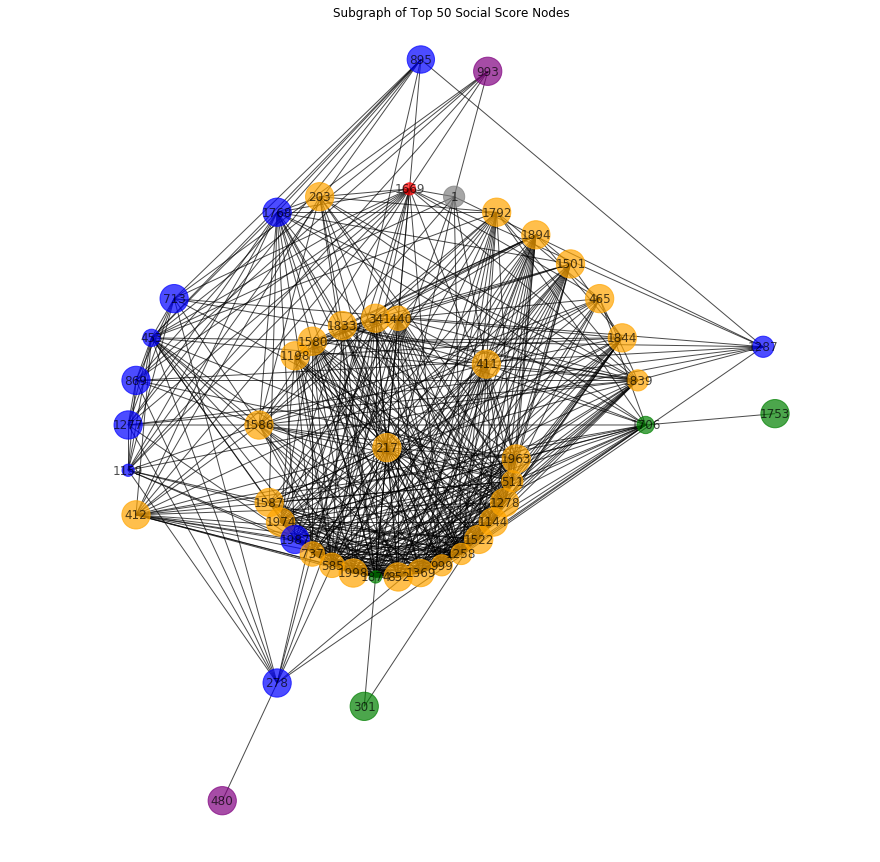

In [600]:

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

pos = graphviz_layout(socialGNx, prog='twopi', args='')
#pos = graphviz_layout(socialGNx, prog='dot', args='')

plt.figure(figsize=(15, 15))
limits=plt.axis('off')
plt.title('Subgraph of Top 50 Social Score Nodes')
nx.draw(socialGNx, pos, node_size=node_size, alpha=0.7, node_color=node_color, with_labels=True)
plt.axis('equal')
plt.show()

## Bridge links in SCC 


In [606]:
bridge_list = list(nx.bridges(SCC))

In [633]:
print "SCC %d bridge links" % len(bridge_list)
#print bridge_list[:10]
nMap = dict()
for (src, dst) in bridge_list:
    if SCC.degree(src) == 1 and SCC.degree(dst) == 1:
        continue
        
    if SCC.degree(src) == 1:
        n1 = dst
        n2 = src
    else:
        n1 = src
        n2 = dst
    
    if n1 not in nMap:
        nMap[n1] = list()
    nMap[n1].append(n2)
    

SCC 1177 bridge links


In [641]:
for n in nMap.keys():
    if SCC.degree(n) > 1:
        continue

print "SCC has %d bridge Nodes" % len(nMap.keys())
bridgeNodes = [n for n in nMap.keys()]
bridgeNodeSet = set(bridgeNodes)
print "%d Social nodes are bridge nodes:" % len(bridgeNodeSet.intersection(topSocialNodeSet))
print "%d CELF nodes are bridge nodes:" % len(bridgeNodeSet.intersection(topCELFNodeSet))

SCC has 117 bridge Nodes
26 Social nodes are bridge nodes:
35 CELF nodes are bridge nodes:


## Spectral Analysis 


In [609]:
L_norm = nx.normalized_laplacian_matrix(SCC)

In [642]:
fiedler_vector = nx.fiedler_vector(SCC)

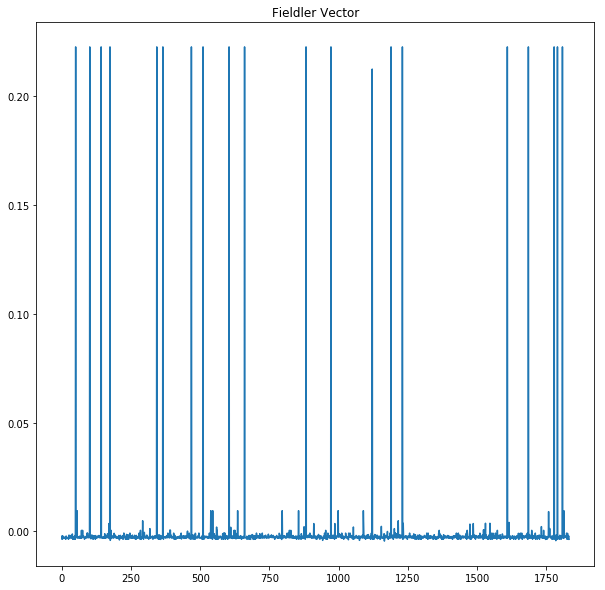

In [643]:
fiedler_list = fiedler_vector.tolist()
plt.figure(figsize=(10,10))
plt.title("Fieldler Vector")
plt.yscale('linear')
plt.plot(fiedler_list)
plt.show()

In [610]:
eigen_values = nx.laplacian_spectrum(SCC)

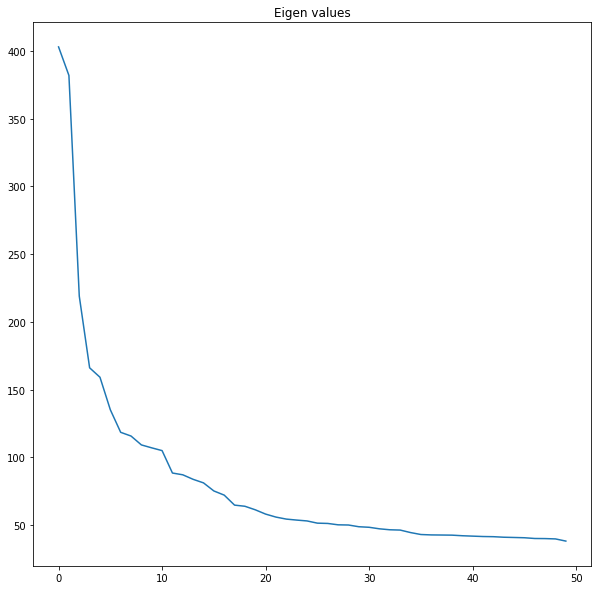

In [620]:
eigen_list = eigen_values.tolist()
eigen_list.sort(reverse=True)
plt.figure(figsize=(10,10))
plt.title("Eigen values")
plt.yscale('linear')
plt.plot(eigen_list[:50])
plt.show()